In [46]:
import numpy as np
import pandas as pd
import csv
import json
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import drive
drive.mount('/content/gdrive')
%matplotlib inline



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
#misc
import gc
import time
import warnings


#viz
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 

# graph viz
import plotly.offline as pyo
from plotly.graph_objs import *
import plotly.graph_objs as go

#map section
import imageio
import folium
import folium.plugins as plugins
from mpl_toolkits.basemap import Basemap


#graph section
import networkx as nx
import heapq  # for getting top n number of things from list,dict


ModuleNotFoundError: ignored

In [12]:
!pip install imageio
!pip install --upgrade --user matplotlib numpy pyproj pyshp OWSLib Pillow

    100% |████████████████████████████████| 3.3MB 8.0MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


In [0]:
PATH_TO_REVIEW_FILE = "/content/gdrive/My Drive/yelp_academic_dataset_review.csv"
PATH_TO_BUSINESS_FILE = "/content/gdrive/My Drive/yelp_academic_dataset_business.csv"
PATH_TO_USER_FILE = "/content/gdrive/My Drive/yelp_academic_dataset_user.csv"

In [0]:
PATH_TO_CHECKIN_FILE = "/content/gdrive/My Drive/yelp_checkin.csv"

In [0]:
reviews = pd.read_csv(PATH_TO_REVIEW_FILE, sep='\t')
users=pd.read_csv(PATH_TO_USER_FILE, sep='\t')
business=pd.read_csv(PATH_TO_BUSINESS_FILE, sep='\t')

In [0]:
checkin=pd.read_csv(PATH_TO_CHECKIN_FILE, sep=',')

In [0]:
users.name = users.name.str.strip('b\'')
users.yelping_since = users.yelping_since.str.strip('b\'')
users.elite = users.elite.str.strip('b\'')
users.user_id = users.user_id.str.strip('b\'')

In [0]:
user_agg=reviews.groupby('user_id').agg({'review_id':['count'],'date':['min','max'],
                                'useful':['sum'],'funny':['sum'],'cool':['sum'],
                               'stars':['mean']})

In [0]:
user_agg=user_agg.sort_values([('review_id','count')],ascending=False)
print("          Top 10 Users in Yelp")
user_agg.head(10)

          Top 10 Users in Yelp


review_id           date                useful  \
                              count            min            max    sum   
user_id                                                                    
b'CxDOIDnH8gp9KXzpBHJYXw'      3739  b'2009-11-09'  b'2018-06-27'  12835   
b'bLbSNkLggFnqwNNzzq-Ijw'      2229  b'2012-05-20'  b'2018-07-01'  26910   
b'PKEzKWv_FktMm2mGPjwd0Q'      1674  b'2008-12-12'  b'2018-07-01'  12804   
b'DK57YibC5ShBmqQl97CKog'      1574  b'2006-02-12'  b'2018-07-01'  19096   
b'QJI9OSEn6ujRCtrX06vs1w'      1324  b'2007-03-20'  b'2016-05-01'   8791   
b'd_TBs6J3twMy9GChqUEXkg'      1245  b'2010-12-27'  b'2018-05-29'   3149   
b'hWDybu_KvYLSdEFzGrniTw'      1220  b'2009-03-08'  b'2018-06-11'   8170   
b'ELcQDlf69kb-ihJfxZyL0A'      1204  b'2011-04-10'  b'2018-06-29'   2243   
b'cMEtAiW60I5wE_vLfTxoJQ'      1201  b'2009-06-12'  b'2018-06-26'   2246   
b'YRcaNlwQ6XXPFDXWtuMGdA'      1195  b'2009-06-16'  b'2018-05-05'   2630   

                           funny   cool     stars  
                             sum    sum      mean  
user_id                                            
b'CxDOIDnH8gp9KXzpBHJYXw'   5883   7606  3.218775  
b'bLbSNkLggFnqwNNzzq-Ijw'  13851  18481  3.274114  
b'PKEzKWv_FktMm2mGPjwd0Q'   5259   8724  3.658303  
b'DK57YibC5ShBmqQl97CKog'  10150  16319  3.817662  
b'QJI9OSEn6ujRCtrX06vs1w'   4118   6159  3.621601  
b'd_TBs6J3twMy9GChqUEXkg'   1443   1902  3.478715  
b'hWDybu_KvYLSdEFzGrniTw'   5459   6517  3.650000  
b'ELcQDlf69kb-ihJfxZyL0A'   1352   1058  2.989203  
b'cMEtAiW60I5wE_vLfTxoJQ'    967   1761  4.081599  
b'YRcaNlwQ6XXPFDXWtuMGdA'   1088   1262  3.395816

In [0]:
#Stalking the top user:
top_user_reviews=reviews[reviews['user_id']=='CxDOIDnH8gp9KXzpBHJYXw']
# Get locations of the places he/she has reviewed
top_user_locs=pd.merge(top_user_reviews,business,on='business_id')
# UNique list of dates from the user's reviews
date_list=list(top_user_locs['date'].unique())
#rearranging data to suit the format needed for folium
data=[]
for date in date_list:
    subset=top_user_locs[top_user_locs['date']==date]
    df=subset[['latitude','longitude','date']]
    data.append(subset[['latitude','longitude']].values.tolist())

In [31]:
#initialize at ontario,Canada (the location our top user is from)
lat = 43.860397
lon = -79.303184
zoom_start=9
print("                     Stalking the top User    ")
# basic map
m = folium.Map(location=[lat, lon], tiles="Cartodb Positron", zoom_start=zoom_start)

hm = plugins.HeatMapWithTime(data,max_opacity=0.3,auto_play=True,display_index=True)
hm.add_to(m)
m

                     Stalking the top User    


In [7]:
!pip install folium

    100% |████████████████████████████████| 81kB 2.5MB/s 


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



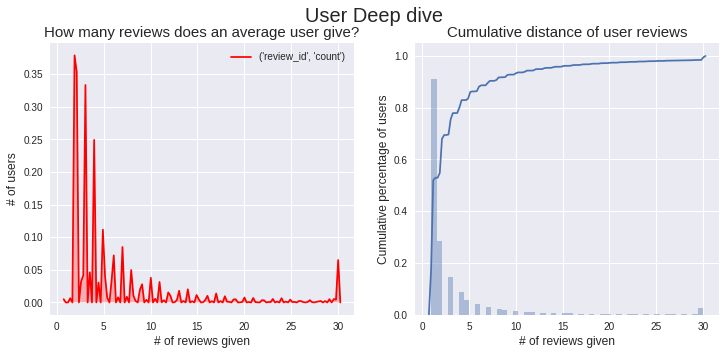

Took -3.361701965332031e-05 s


NameError: ignored

In [39]:
# Cap max reviews to 30 for better visuals
user_agg[('review_id','count')].loc[user_agg[('review_id','count')]>30] = 30
plt.figure(figsize=(12,5))
plt.suptitle("User Deep dive",fontsize=20)
gridspec.GridSpec(1,2)
plt.subplot2grid((1,2),(0,0))
#Cumulative Distribution
ax=sns.kdeplot(user_agg[('review_id','count')],shade=True,color='r')
plt.title("How many reviews does an average user give?",fontsize=15)
plt.xlabel('# of reviews given', fontsize=12)
plt.ylabel('# of users', fontsize=12)

#Cumulative Distribution
plt.subplot2grid((1,2),(0,1))
sns.distplot(user_agg[('review_id','count')],
             kde_kws=dict(cumulative=True))
plt.title("Cumulative distance of user reviews",fontsize=15)
plt.ylabel('Cumulative percentage of users', fontsize=12)
plt.xlabel('# of reviews given', fontsize=12)

plt.show()
end_time=time.time()
start_time=time.time()
print("Took",end_time-start_time,"s")


In [0]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [72]:
#checkins exploration
df=checkin.groupby(['weekday','hour'])['checkins'].sum()
df=df.reset_index()
df=df.pivot(index='hour',columns='weekday')[['checkins']]
df.columns = df.columns.droplevel()
df=df.reset_index()
# Workaround for not being able to sort the values by hour
df.hour=df.hour.apply(lambda x: str(x).split(':')[0])
df.hour=df.hour.astype(int)
# Sort the hour column 
df=df.sort_values('hour')
df=df[['hour','Mon', 'Tue','Wed','Thu','Fri','Sat', 'Sun' ]]
# df=df.set_index('hour')
cm = sns.light_palette("orange", as_cmap=True)
#highlight the max of each column
df.style.apply(highlight_max, color='darkorange', axis=0)

weekday,hour,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,0,558,127,680,1720,2321,16442,1028
11,1,849,158,914,494,540,81753,795
16,2,1247,105,275,2947,639,2324,725
17,3,1678,77,5177,185,169,3340,766
18,4,2437,73,43,91,75,627,58
19,5,2220,193,62,38,61,722,72
20,6,1813,84,13,28,32,227,69
21,7,2118,101,23,18,53,360,79
22,8,20,38,155,393,3422,210,33
23,9,29,48,347,151,1017,416,97


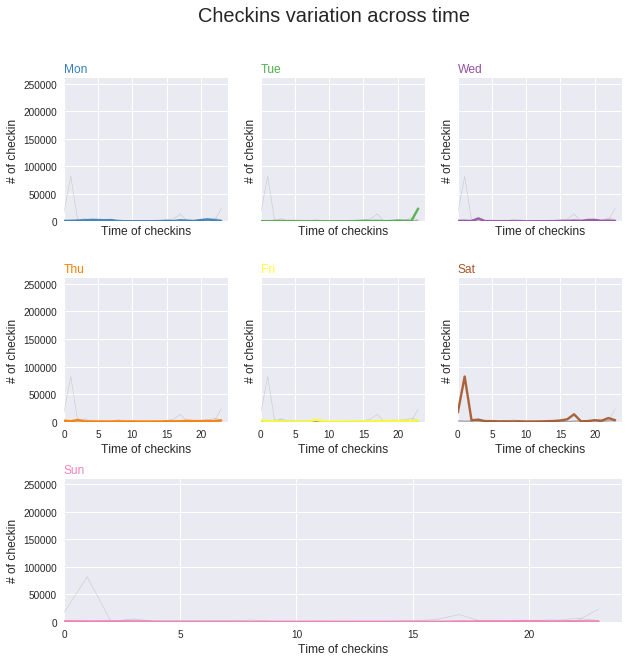

In [80]:
#https://python-graph-gallery.com/125-small-multiples-for-line-chart/  
# Initialize the figure
plt.style.use('seaborn-darkgrid')
# create a color palette
palette = plt.get_cmap('Set1')
plt.figure(figsize=(10,10))
plt.suptitle("Checkins variation across time",fontsize=20)
gridspec.GridSpec(3,3)
plt.subplots_adjust(hspace=0.4)

# multiple line plot
num=0
for column in df.drop('hour', axis=1):
    num+=1
    # Find the right spot on the plot
    
    if num==7:  # adjustment to fit sunday
        plt.subplot2grid((3,3),(2,0),colspan=3)
    else:
        plt.subplot(3,3, num)
    
    # plot every groups, but discreet
    for v in df.drop('hour', axis=1):
        plt.plot(df['hour'], df[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
    # Plot the lineplot
    plt.plot(df['hour'], df[column], marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
    # Same limits for everybody!
    plt.xlim(0,24)
    plt.ylim(-2,260000)
    # Not ticks everywhere
    if num in range(4) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
       
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))
         
    plt.ylabel('# of checkin', fontsize=12)
    plt.xlabel('Time of checkins', fontsize=12)